In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.8.2'

In [2]:
(X_treinamento, y_treinamento), (_,_) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
X_treinamento.shape, y_treinamento.shape

((60000, 28, 28), (60000,))

4


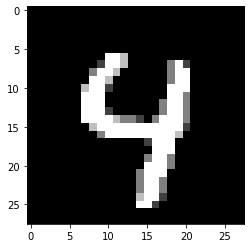

In [4]:
i = np.random.randint(0, 60000)
print(y_treinamento[i])
plt.imshow(X_treinamento[i], cmap='gray');

In [5]:
X_treinamento = X_treinamento.reshape(X_treinamento.shape[0], 28, 28, 1).astype('float32')

In [6]:
X_treinamento.shape

(60000, 28, 28, 1)

In [7]:
X_treinamento[0].min(), X_treinamento[0].max()

(0.0, 255.0)

In [8]:
# X_treinamento = X_treinamento / 255
X_treinamento = (X_treinamento - 127.5) / 127.5

In [9]:
X_treinamento[0].min(), X_treinamento[0].max()

(-1.0, 1.0)

In [10]:
buffer_size = 60000
batch_size = 256 # mini batch gradient descent

In [11]:
buffer_size / batch_size

234.375

In [12]:
X_treinamento = tf.data.Dataset.from_tensor_slices(X_treinamento).shuffle(buffer_size).batch(batch_size)

In [13]:
X_treinamento

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# Generator

In [14]:
# 100 -> 12544
def create_generator():
  network = tf.keras.Sequential()

  network.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(128, (5,5), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(64, (5,5), padding='same', use_bias=False, strides=(2,2)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(1, (5,5), padding='same', use_bias=False, strides=(2,2), activation='tanh'))

  network.summary()

  return network

In [15]:
gerador = create_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [16]:
gerador.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_input')>

In [17]:
ruido = tf.random.normal([1, 100])
ruido

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.49917376, -0.88941014,  0.31550175, -0.14224797, -0.18126476,
        -0.8522827 , -0.58483773, -0.98706603,  1.0678728 ,  0.46847624,
         0.5771563 ,  0.32835546, -1.8081529 , -0.27660224, -1.1213881 ,
         0.8925452 , -1.1833264 ,  0.4440888 ,  0.81545186,  0.16772014,
         1.0056938 ,  0.16930616, -0.16065647, -1.1560284 , -1.2456756 ,
        -0.3392996 , -0.11598944, -0.9817553 ,  0.3203611 , -0.9671462 ,
        -2.362559  ,  0.57633424,  0.27360672,  0.0269295 , -1.30857   ,
        -1.4989141 ,  0.42051998, -0.5741951 ,  1.3206161 , -0.9581489 ,
        -0.33254424, -0.16464116, -0.23041593,  1.321147  ,  0.65686667,
         0.56315   ,  1.0825874 , -0.59098506,  0.43770045,  1.1783981 ,
        -0.58696926,  1.5597247 , -1.885298  , -1.1263893 ,  1.299325  ,
         0.39802083, -0.6007509 , -1.3770516 ,  0.63091403,  1.1085999 ,
         1.9939053 , -0.5749818 ,  0.28656483,  0.6478757 , -0.32644215,
 

In [18]:
imagem_gerada = gerador(ruido, training = False)

In [19]:
imagem_gerada.shape

TensorShape([1, 28, 28, 1])

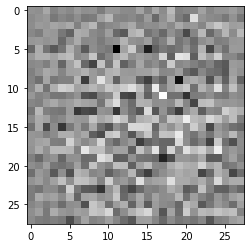

In [20]:
plt.imshow(imagem_gerada[0, :, :, 0], cmap='gray');

# Discriminator

In [21]:
def create_discriminator():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()
  return network

In [22]:
discriminador = create_discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [23]:
discriminador.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

In [24]:
discriminador(imagem_gerada, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00112096]], dtype=float32)>

# Error calculation

In [25]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [26]:
def discriminador_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [27]:
def gerador_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [28]:
gerador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Training GAN

In [29]:
X_treinamento

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [30]:
epocas = 100
dimensao_ruido = 100
numero_imagens = 16

In [31]:
batch_size, dimensao_ruido

(256, 100)

In [32]:
@tf.function
def treinamento(imagens):
  ruido = tf.random.normal([batch_size, dimensao_ruido])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    imagens_geradas = gerador(ruido, training=True)

    expected_output = discriminador(imagens, training=True)
    fake_output = discriminador(imagens_geradas, training=True)

    gen_loss = gerador_loss(fake_output)
    disc_loss = discriminador_loss(expected_output, fake_output)

  gradientes_gerador = gen_tape.gradient(gen_loss, gerador.trainable_variables)
  gradientes_discriminador = disc_tape.gradient(disc_loss, discriminador.trainable_variables)

  gerador_optimizer.apply_gradients(zip(gradientes_gerador, gerador.trainable_variables))
  discriminador_optimizer.apply_gradients(zip(gradientes_discriminador, discriminador.trainable_variables))

In [33]:
imagens_teste = tf.random.normal([numero_imagens, dimensao_ruido])
imagens_teste.shape

TensorShape([16, 100])

In [34]:
60000 / 256

234.375

In [35]:
def treina_gan(dataset, epocas, imagens_teste):
  for epoca in range(epocas):
    for imagem_batch in dataset:
      #print(imagem_batch.shape)
      treinamento(imagem_batch)

    print('Época: ', epoca + 1)
    imagens_geradas = gerador(imagens_teste, training=False)
    fig = plt.figure(figsize=(10,10))
    for i in range(imagens_geradas.shape[0]):
      plt.subplot(4,4,i+1)
      plt.imshow(imagens_geradas[i, :,:,0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

Época:  1


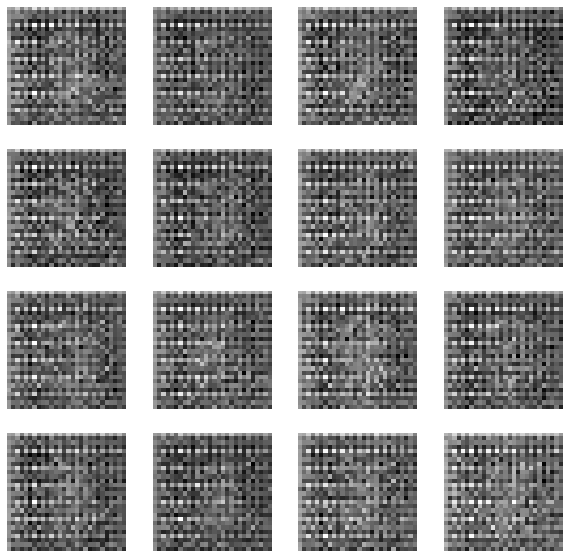

Época:  2


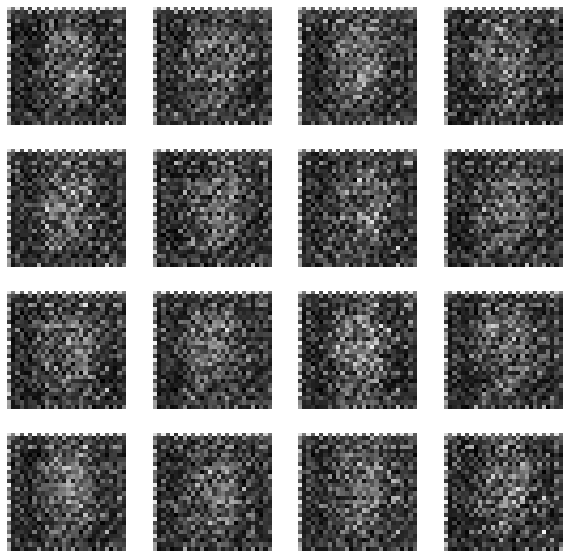

Época:  3


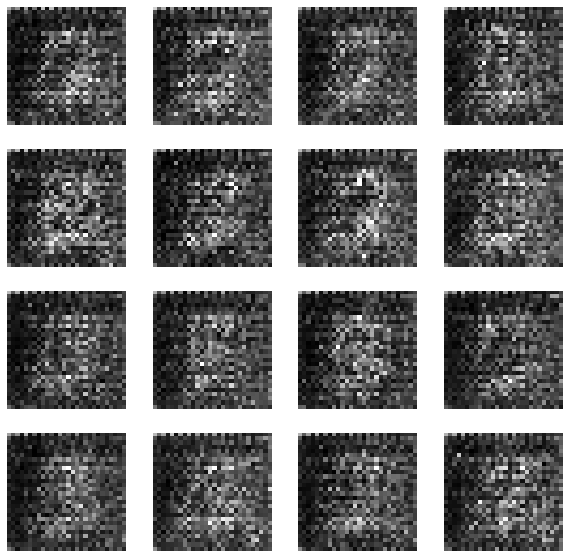

Época:  4


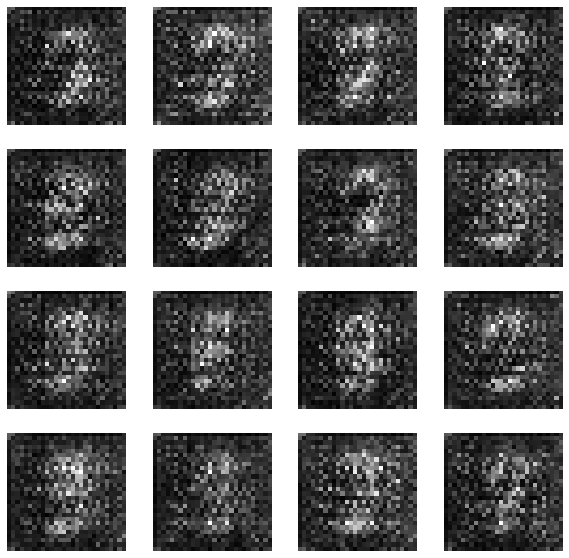

Época:  5


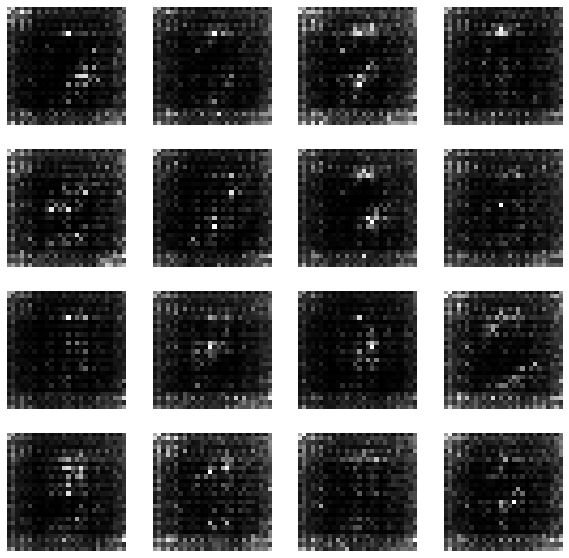

Época:  6


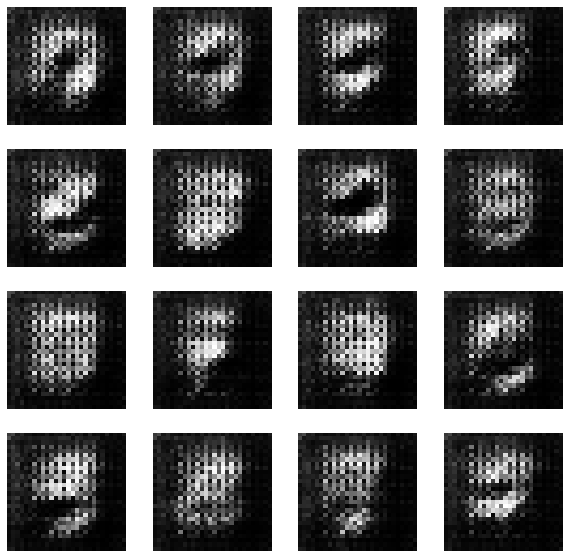

Época:  7


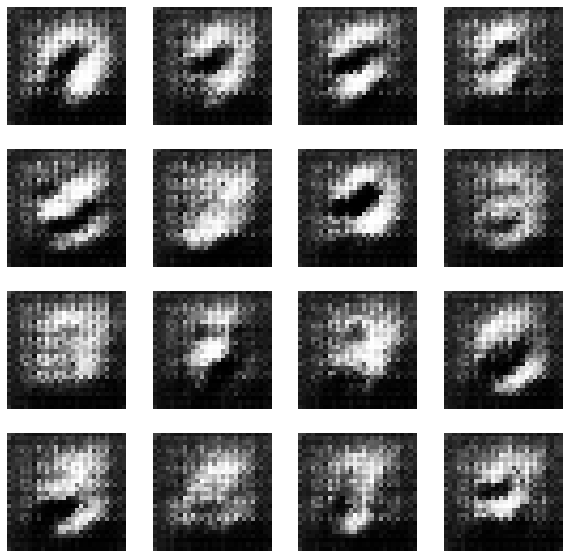

Época:  8


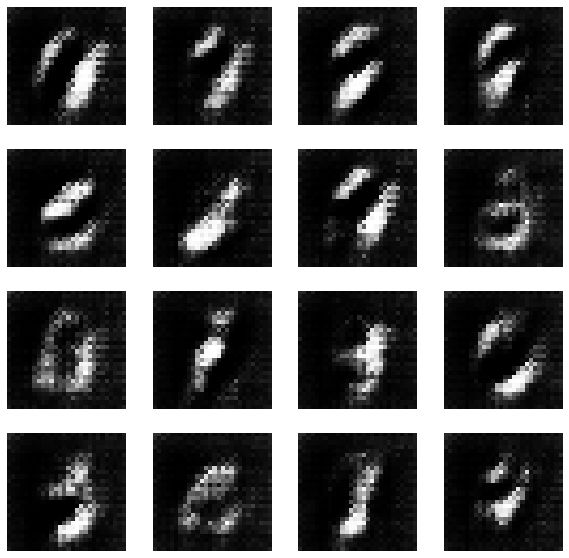

Época:  9


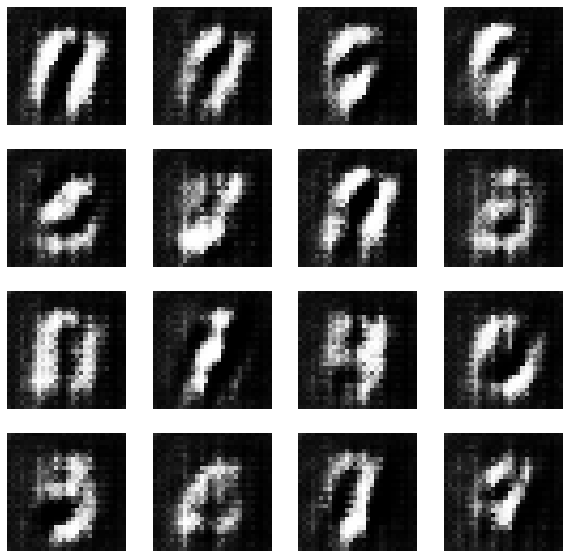

Época:  10


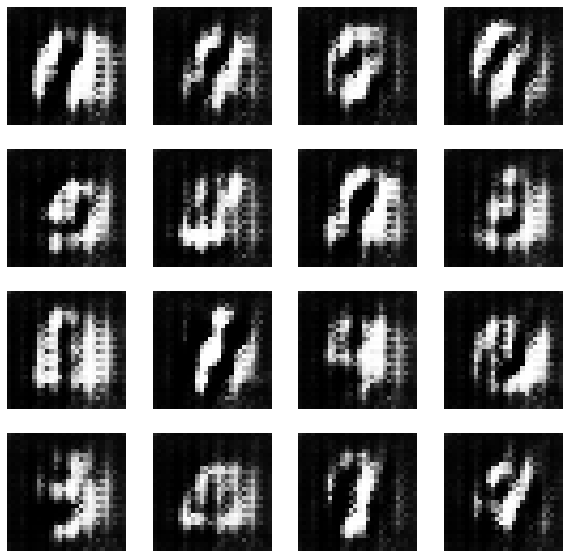

Época:  11


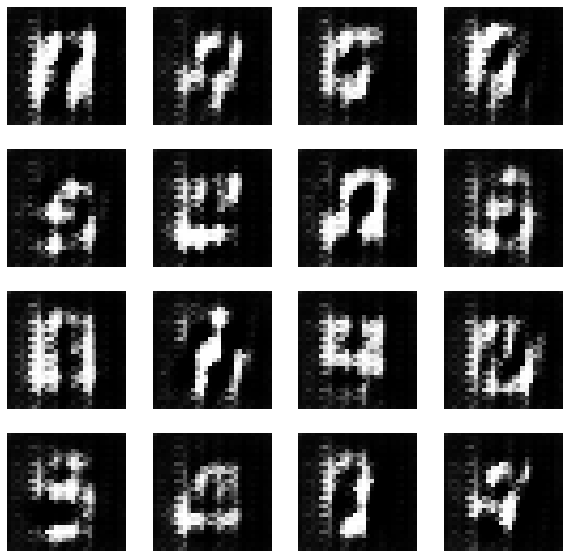

Época:  12


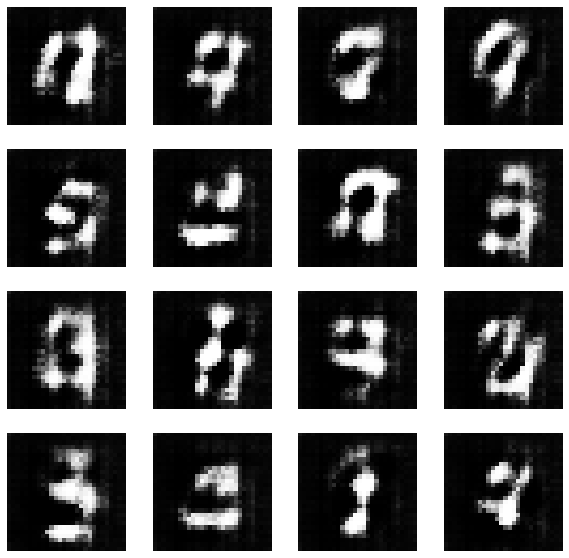

Época:  13


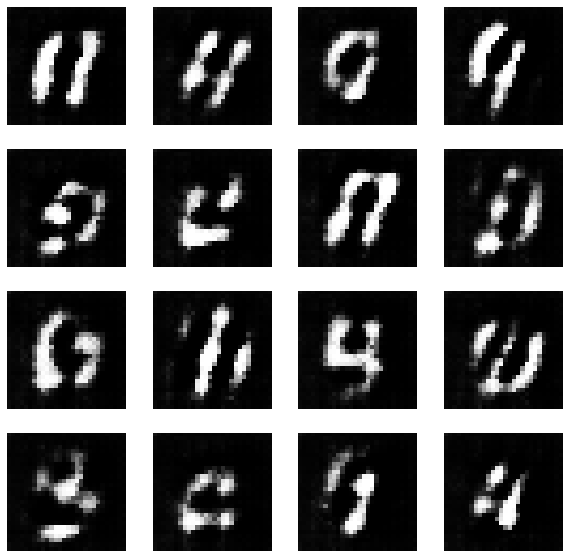

Época:  14


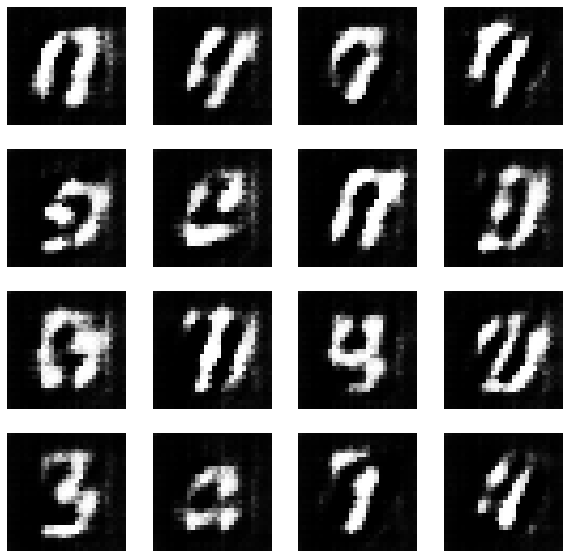

Época:  15


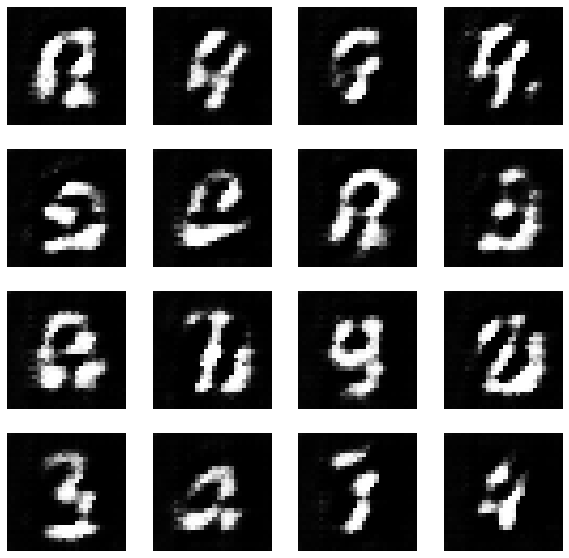

Época:  16


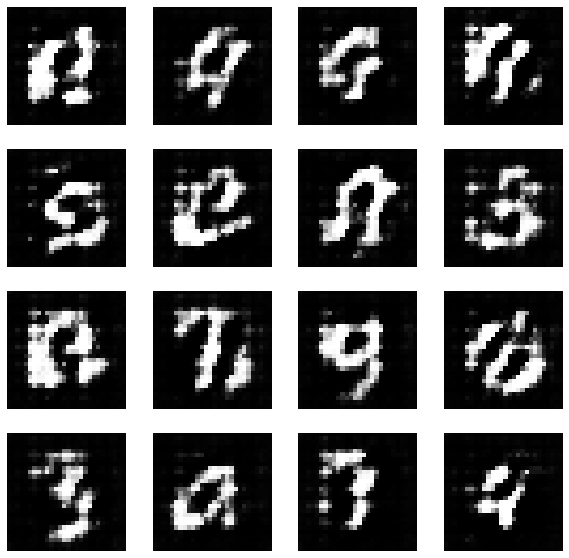

Época:  17


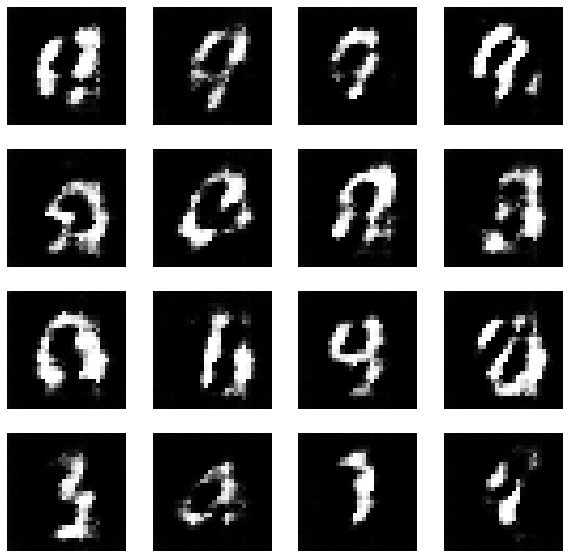

Época:  18


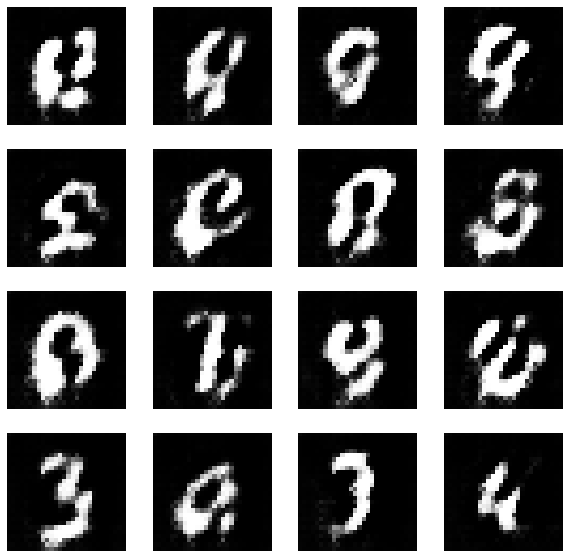

Época:  19


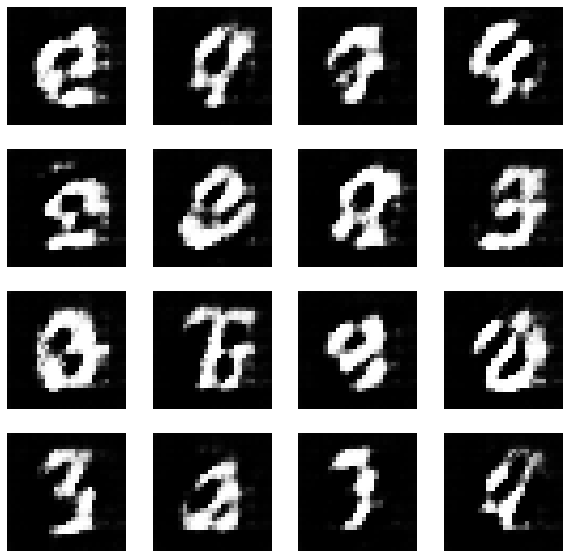

Época:  20


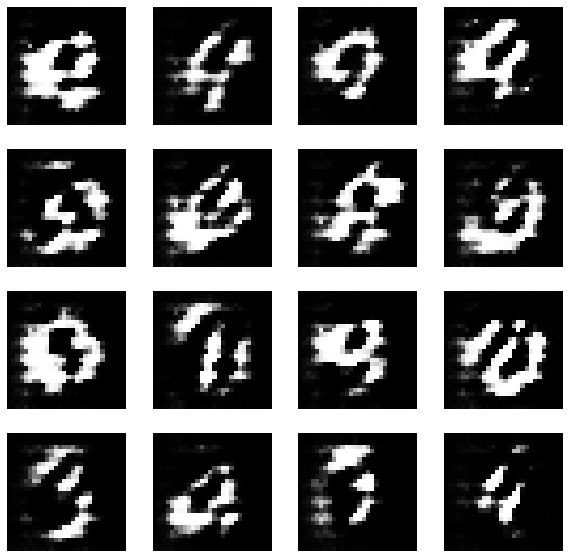

Época:  21


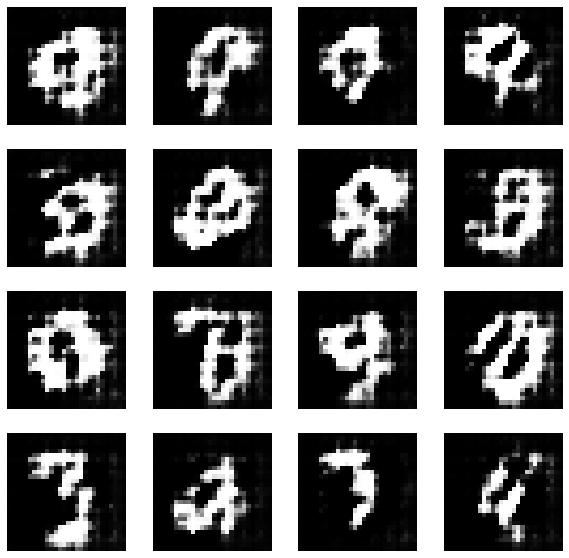

Época:  22


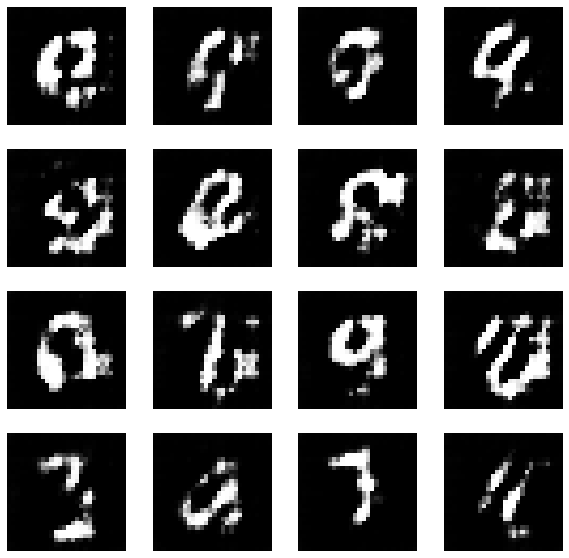

Época:  23


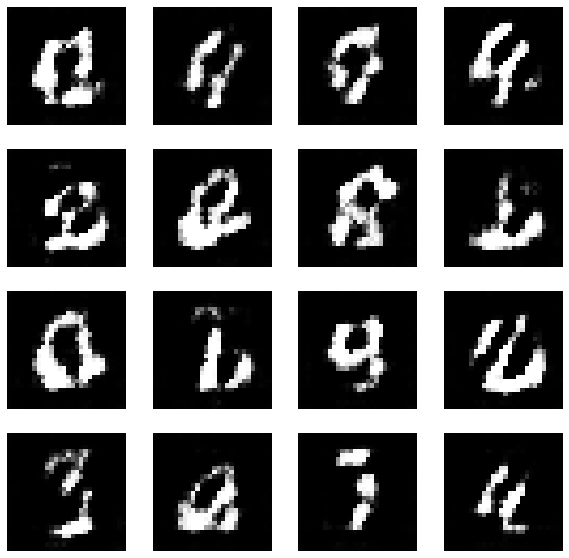

Época:  24


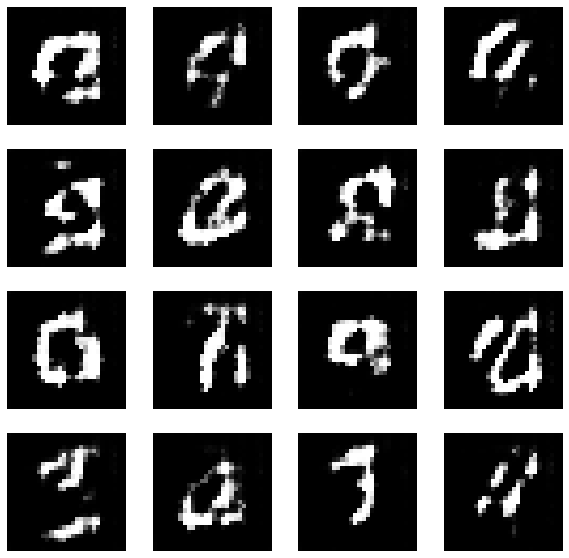

Época:  25


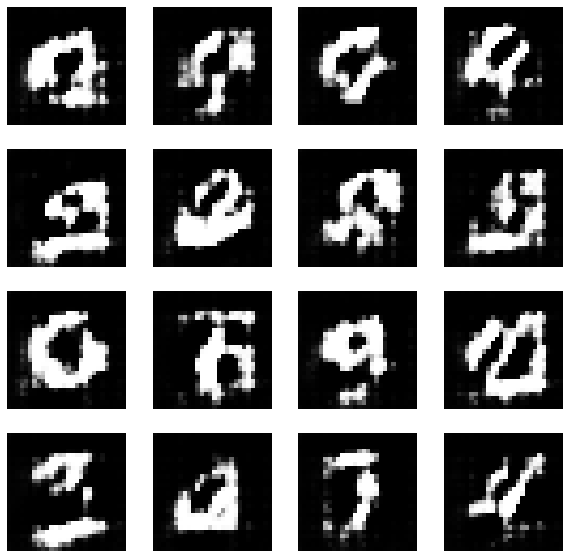

Época:  26


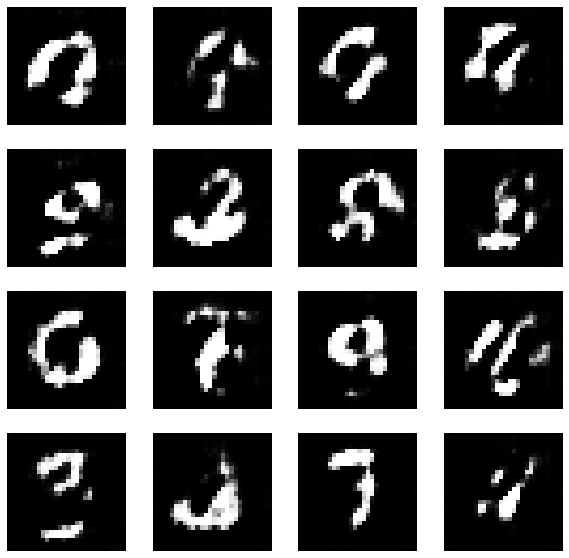

Época:  27


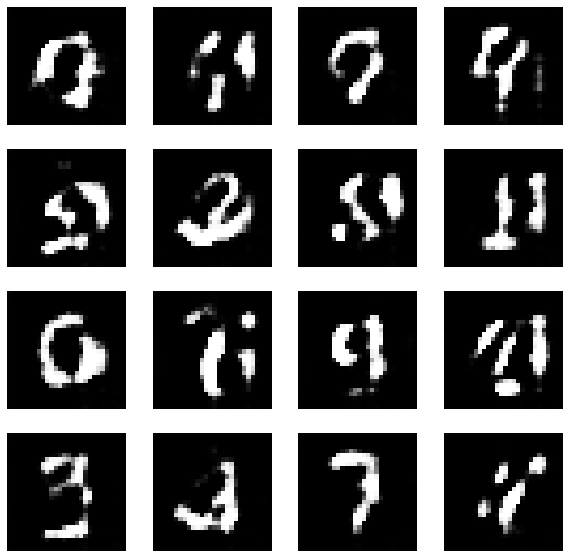

Época:  28


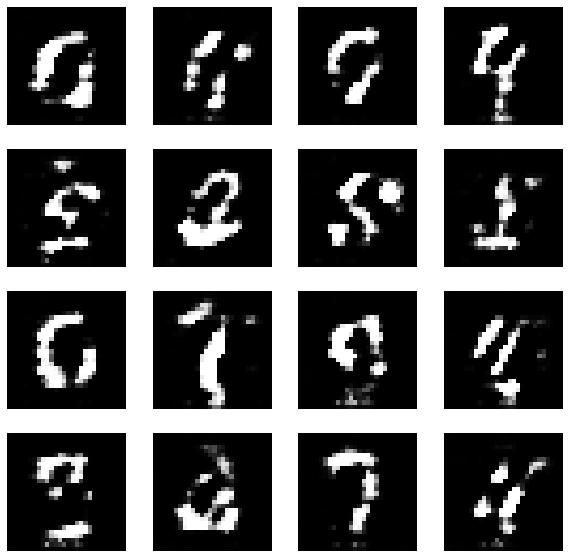

Época:  29


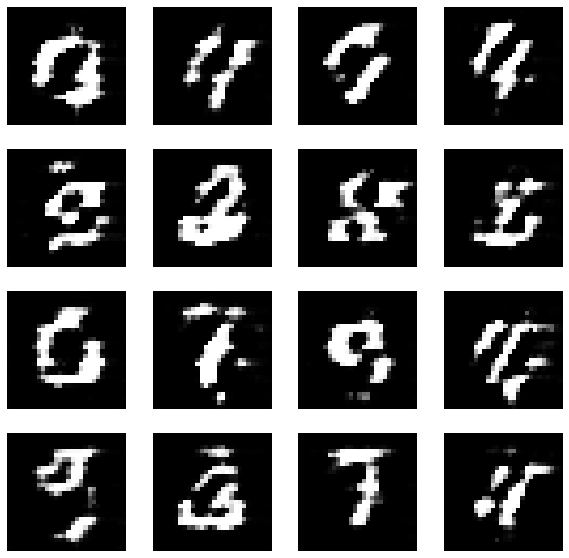

Época:  30


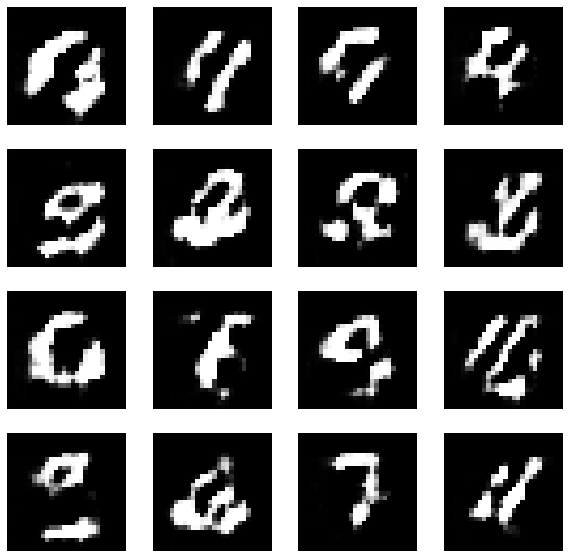

Época:  31


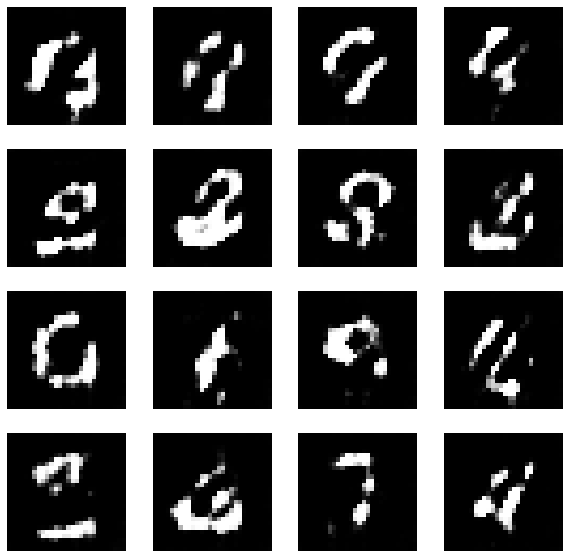

Época:  32


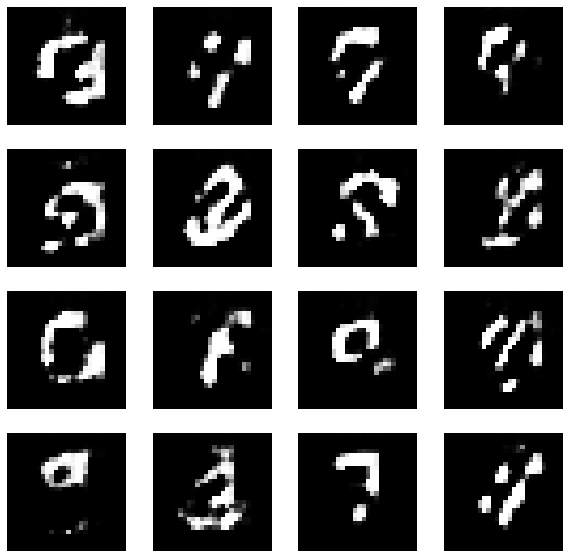

Época:  33


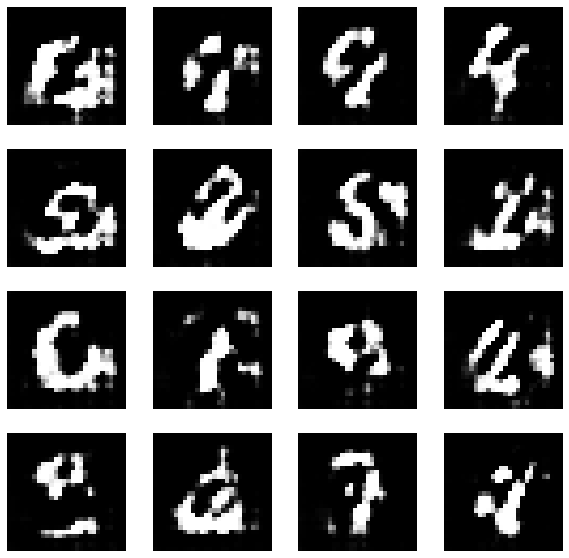

Época:  34


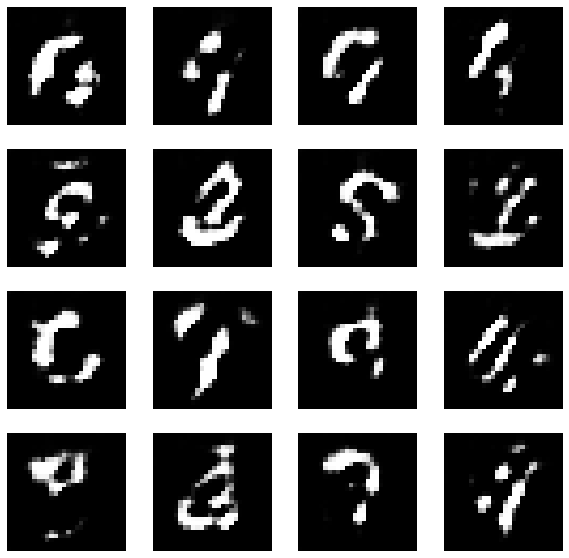

Época:  35


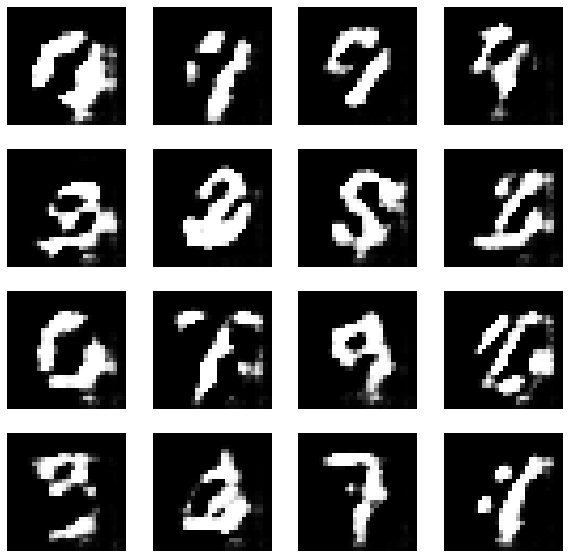

Época:  36


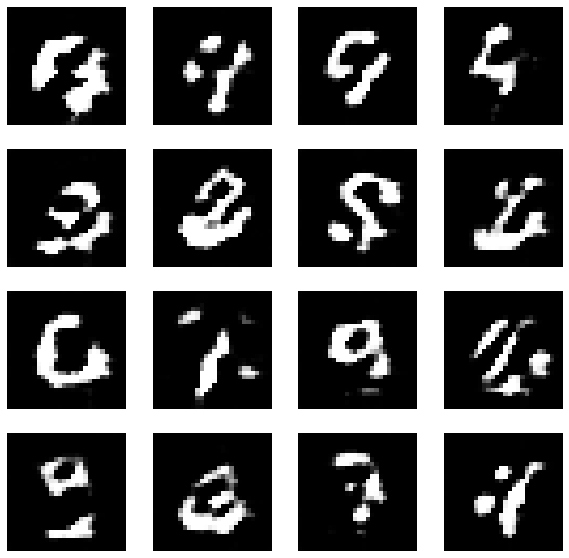

Época:  37


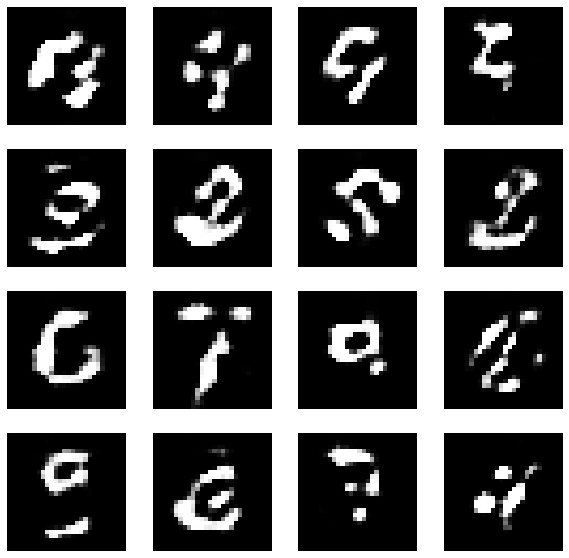

Época:  38


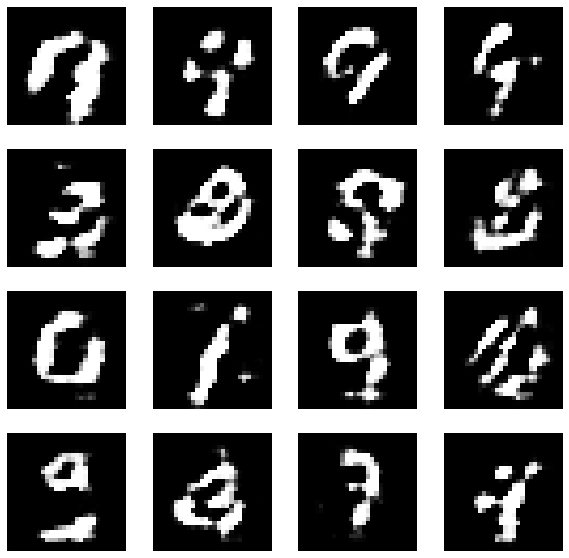

Época:  39


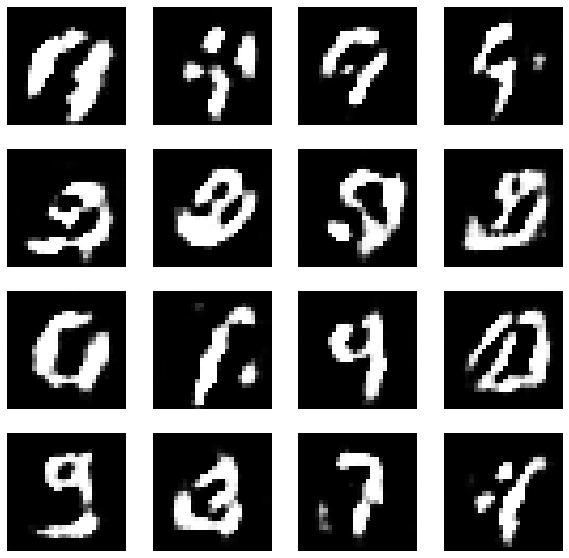

Época:  40


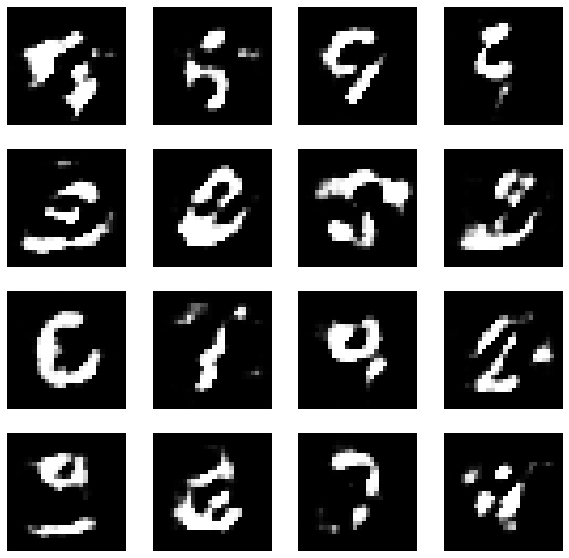

Época:  41


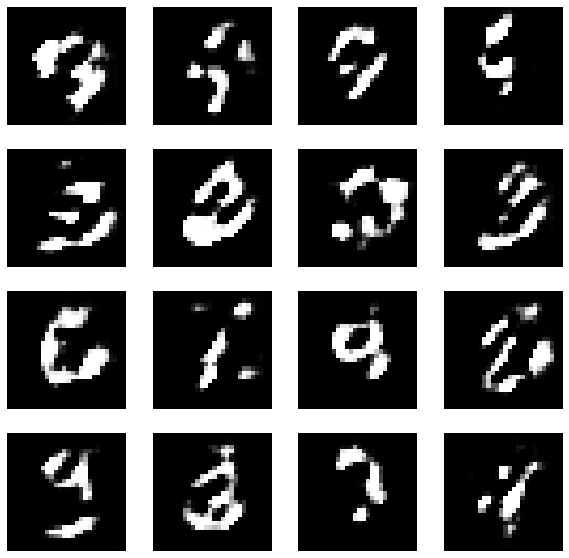

Época:  42


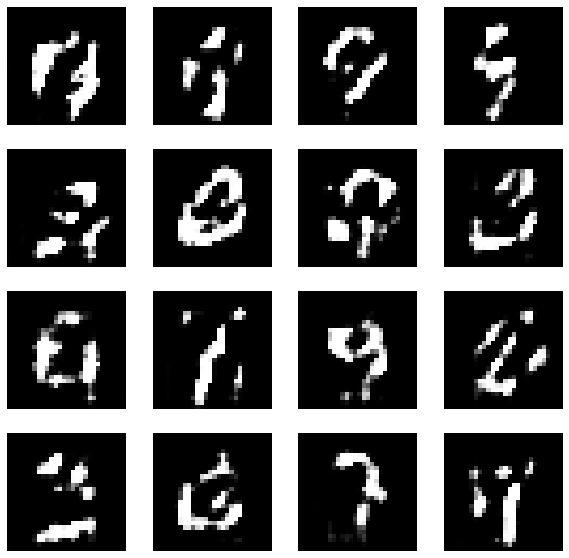

Época:  43


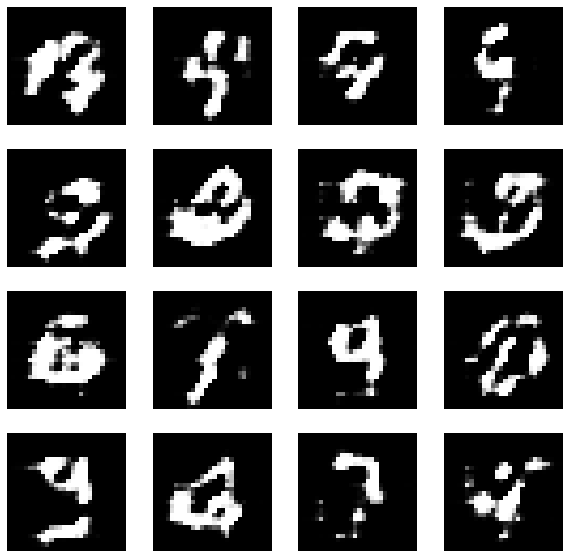

Época:  44


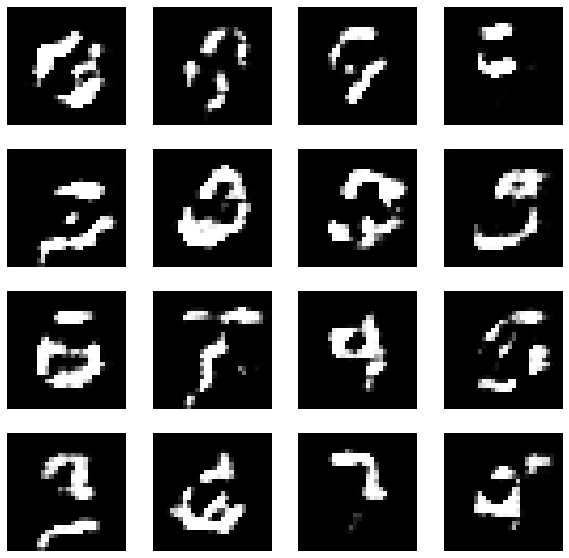

Época:  45


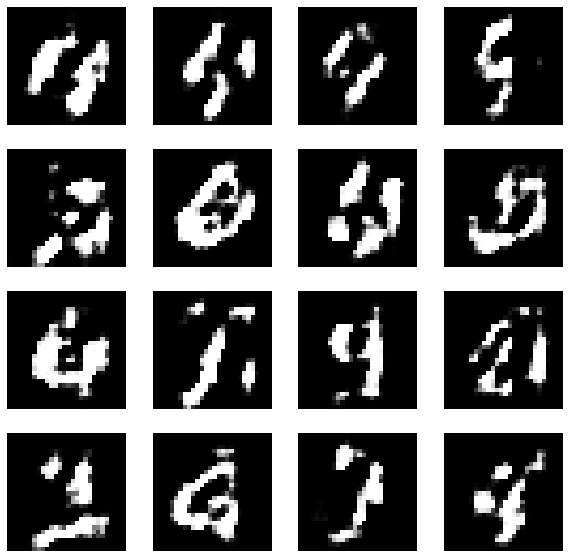

Época:  46


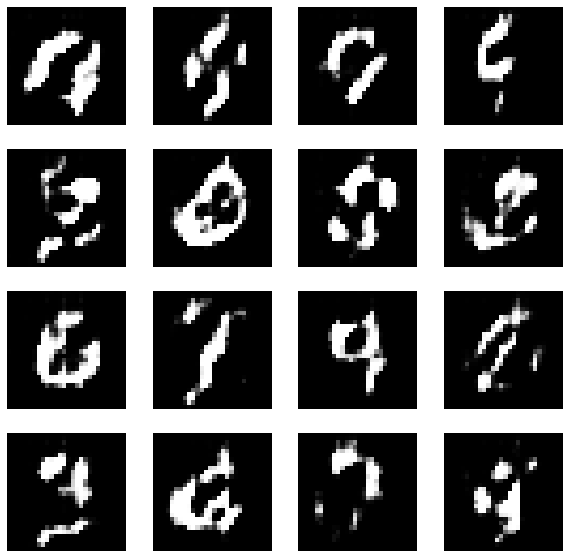

Época:  47


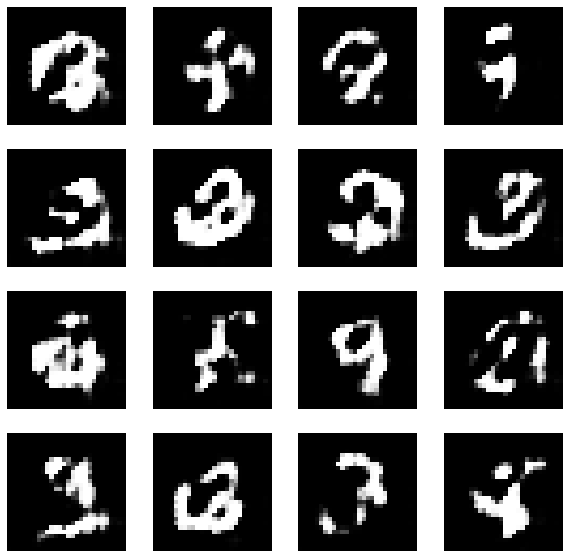

Época:  48


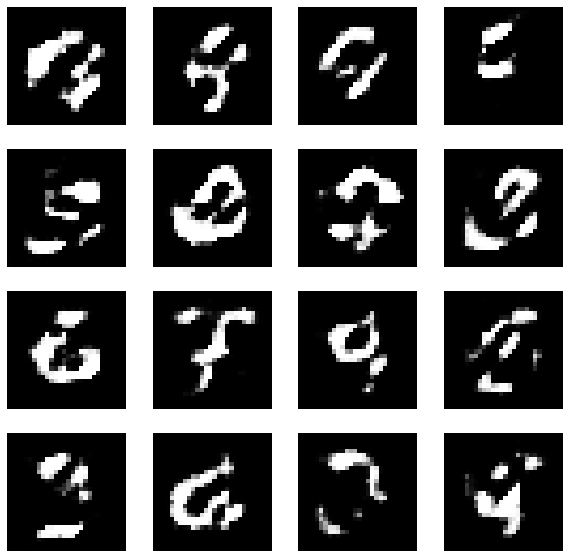

Época:  49


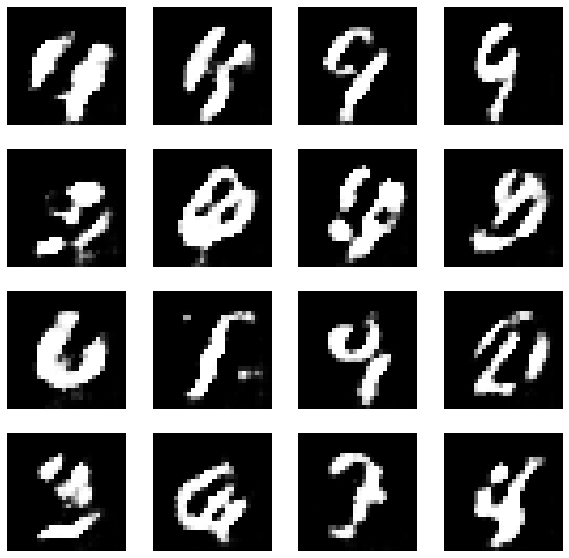

Época:  50


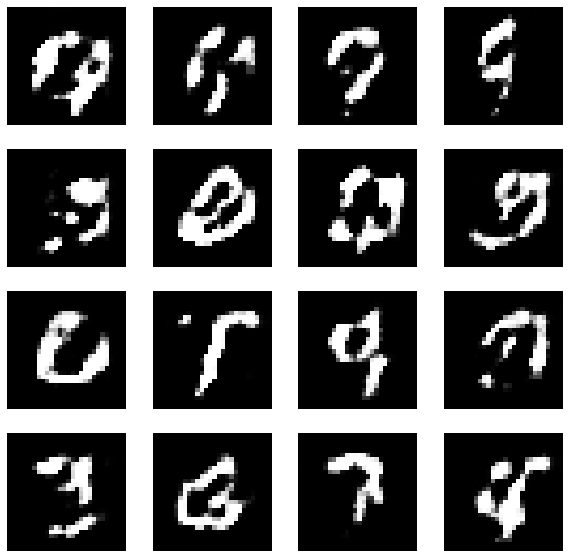

Época:  51


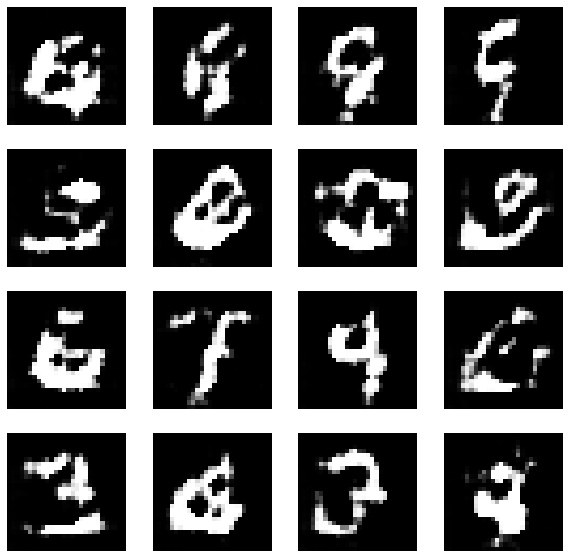

Época:  52


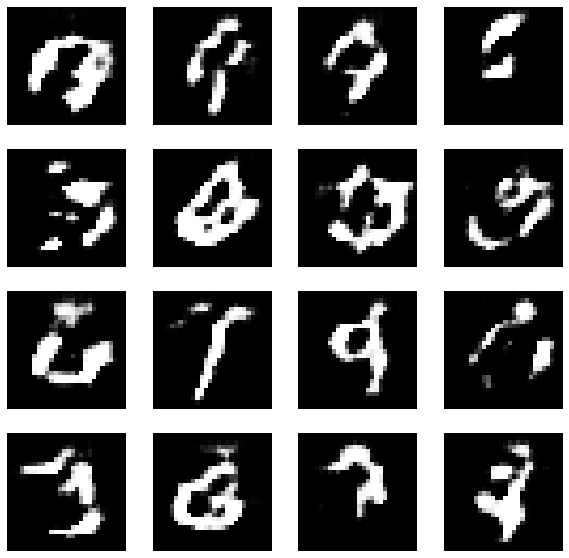

Época:  53


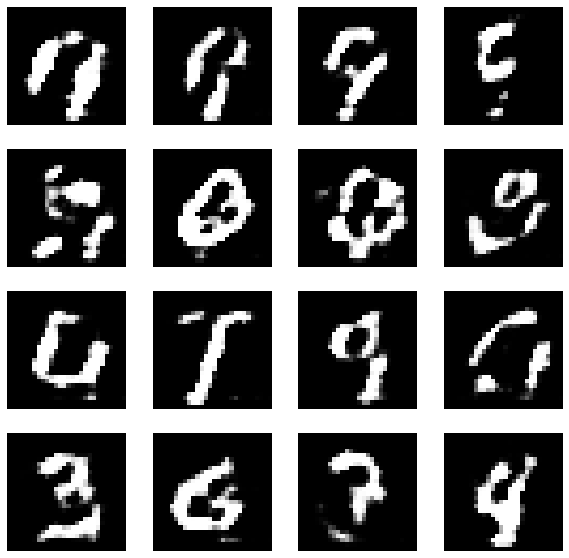

Época:  54


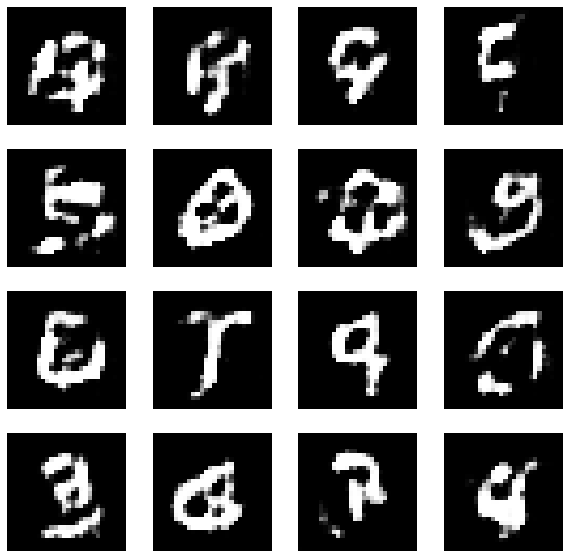

Época:  55


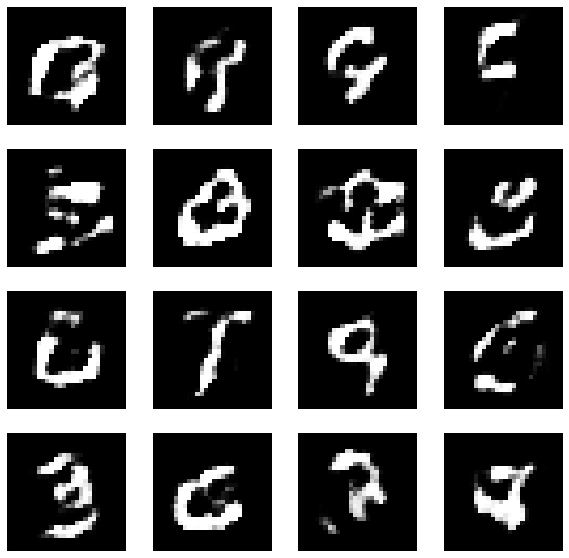

Época:  56


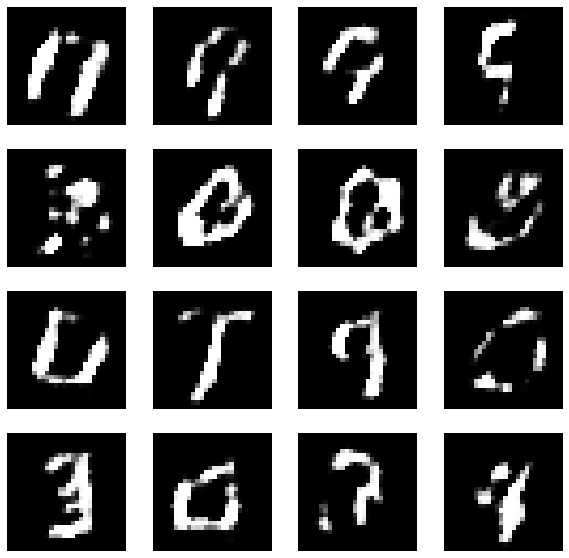

Época:  57


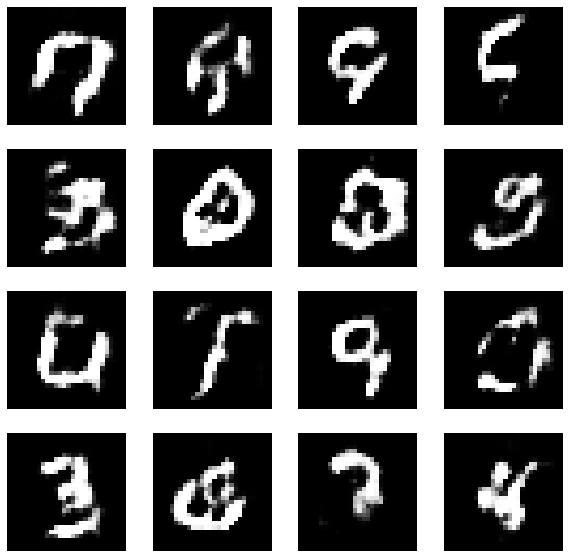

Época:  58


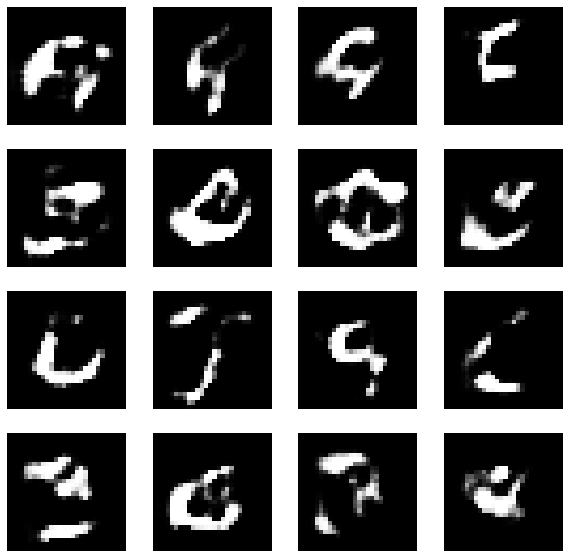

Época:  59


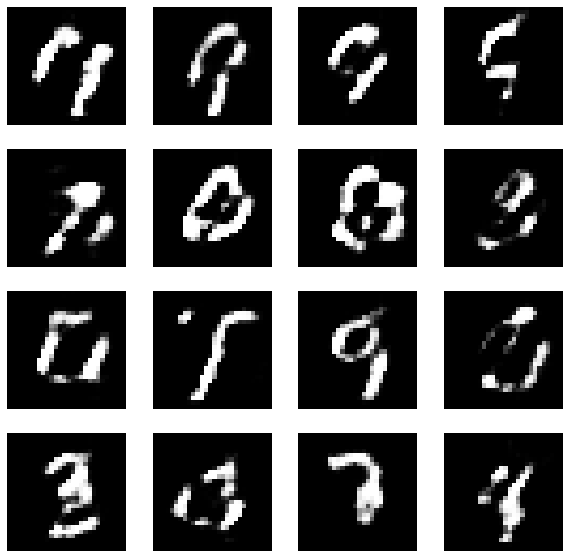

Época:  60


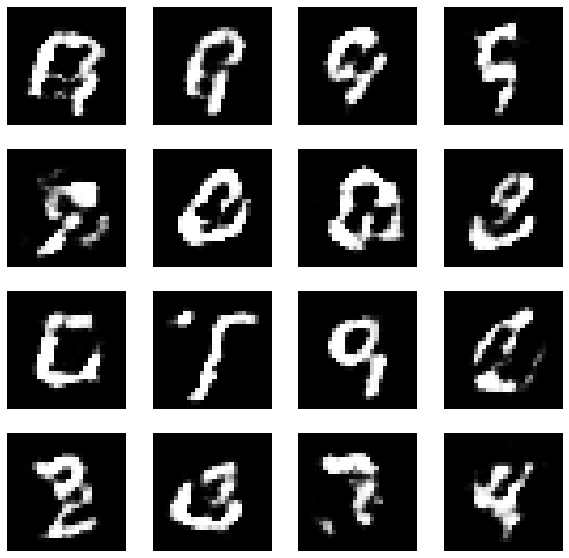

Época:  61


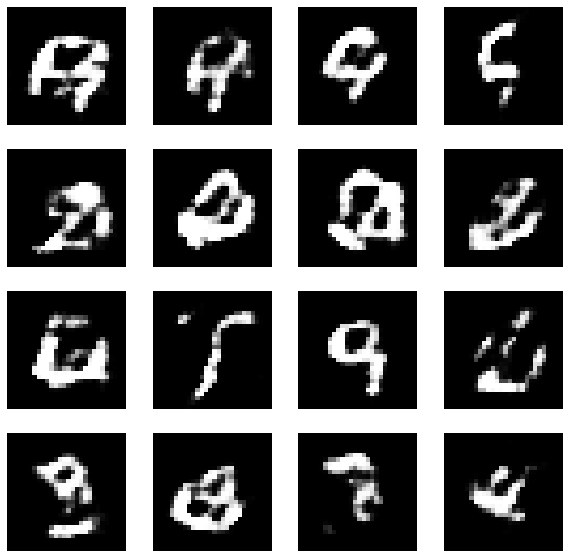

Época:  62


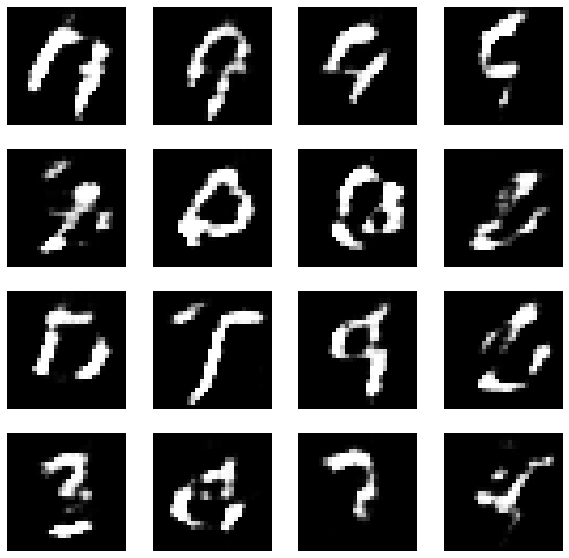

Época:  63


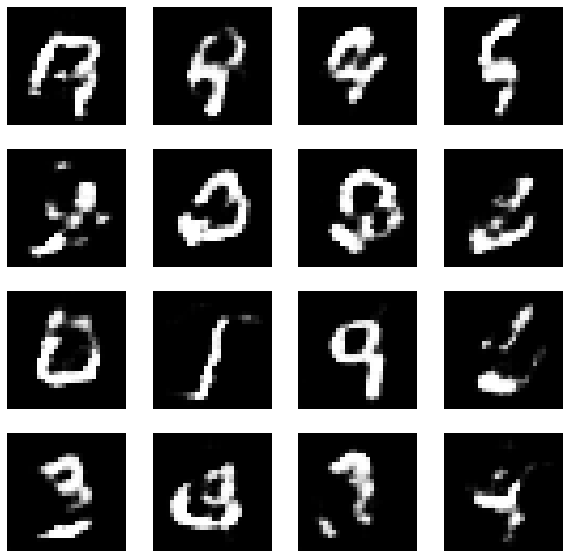

Época:  64


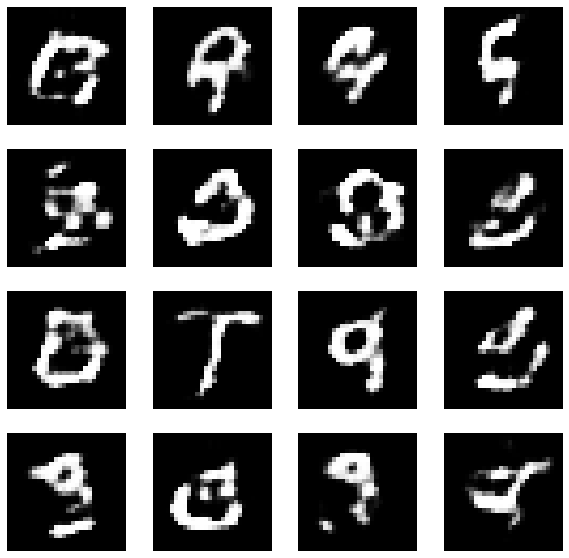

Época:  65


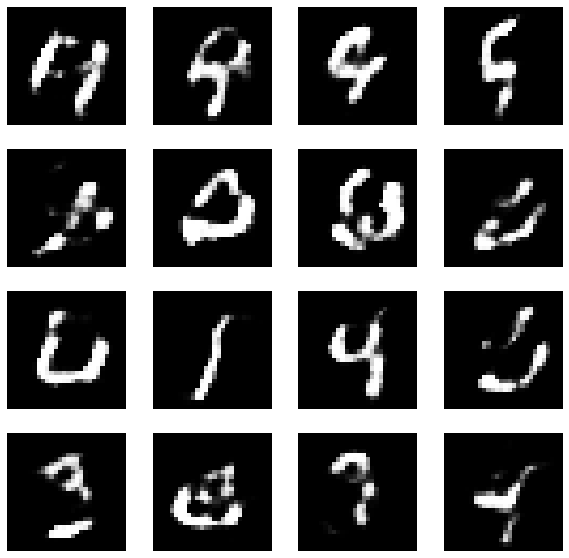

Época:  66


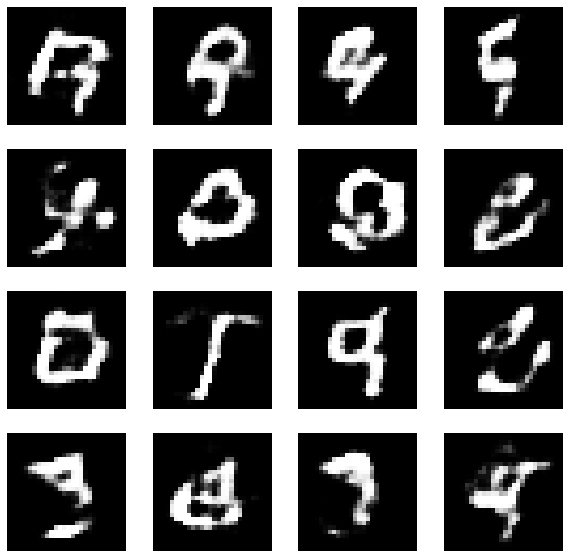

Época:  67


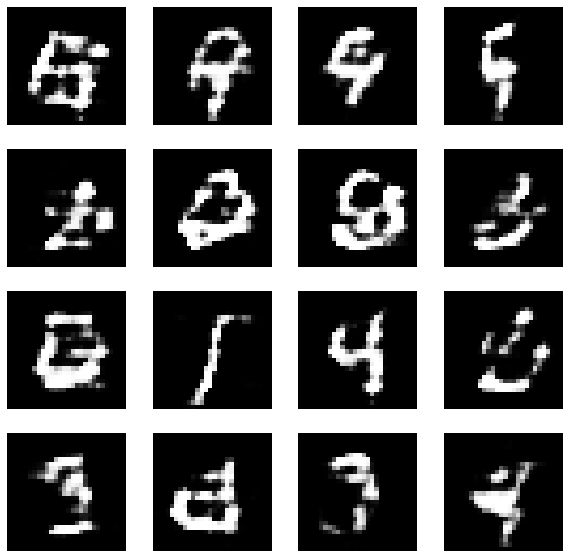

Época:  68


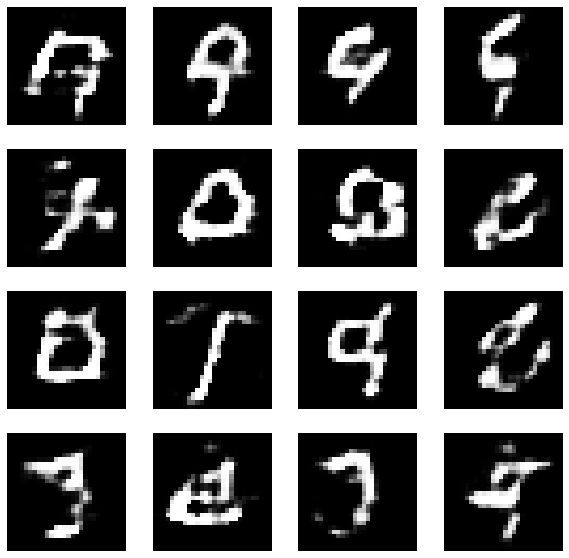

Época:  69


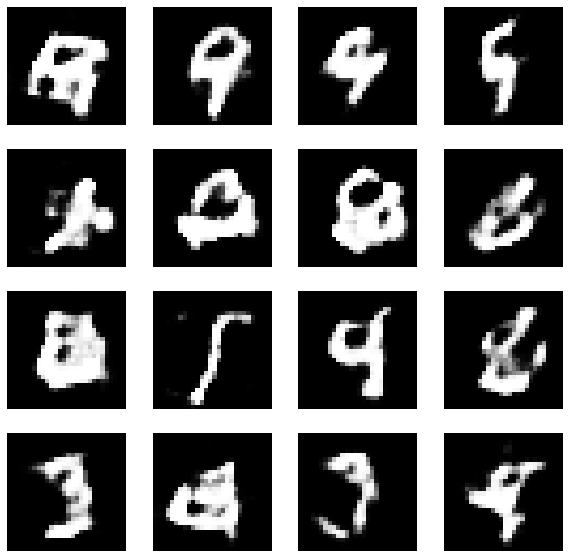

Época:  70


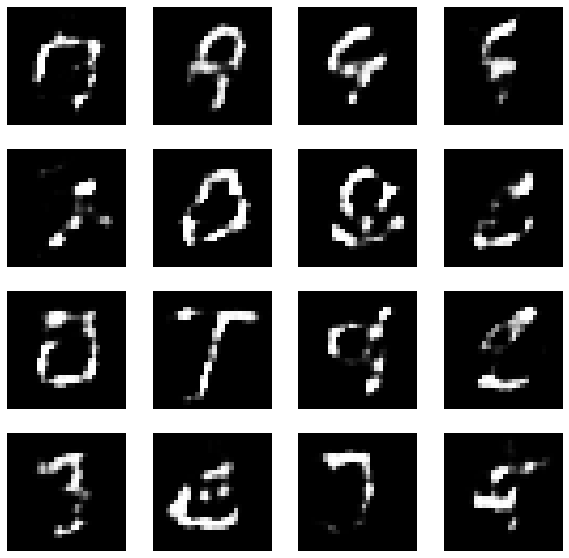

Época:  71


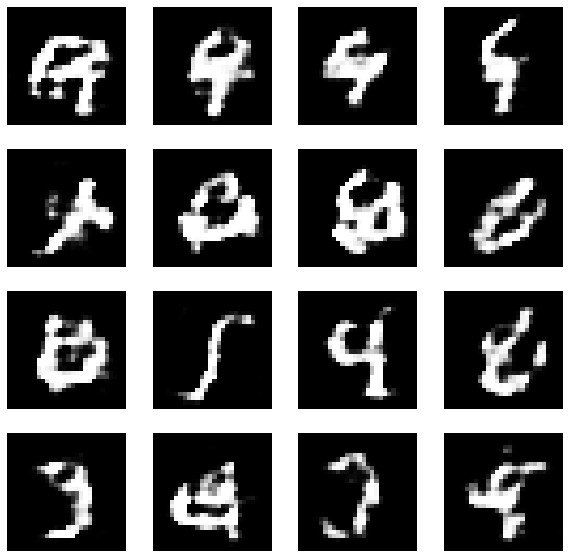

Época:  72


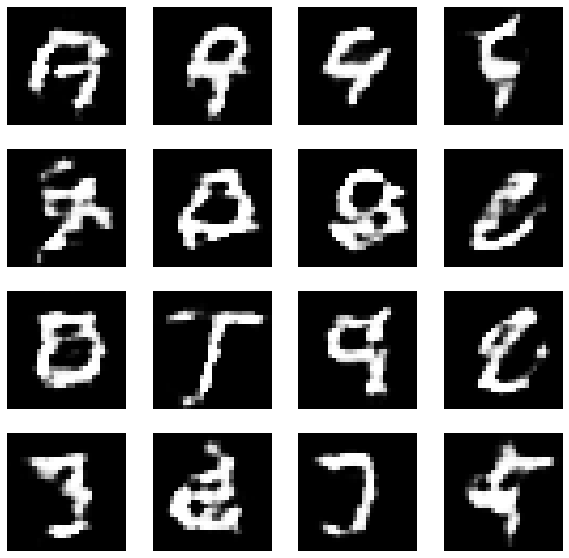

Época:  73


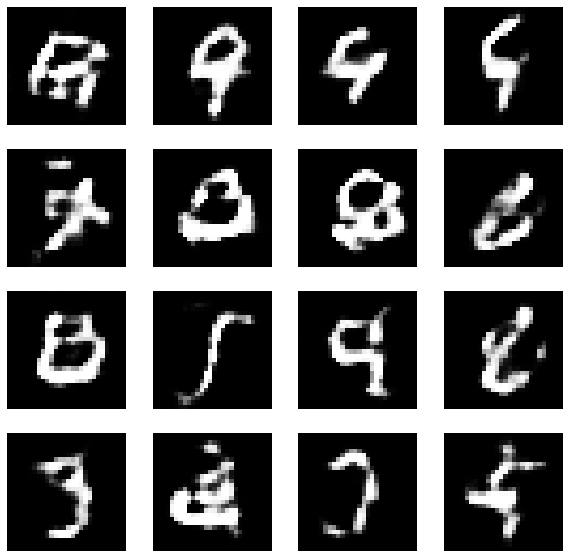

Época:  74


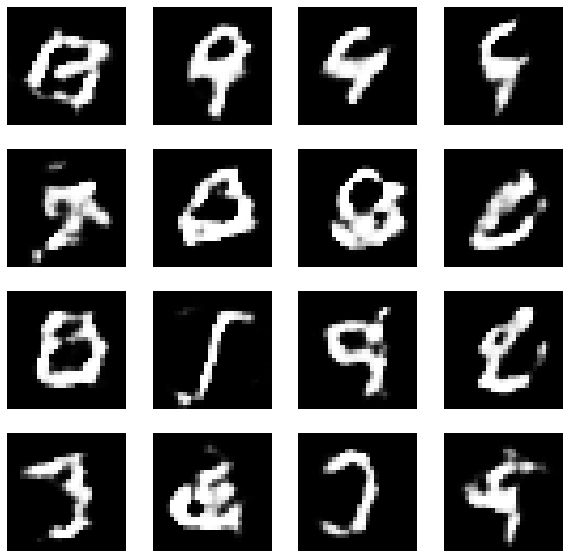

Época:  75


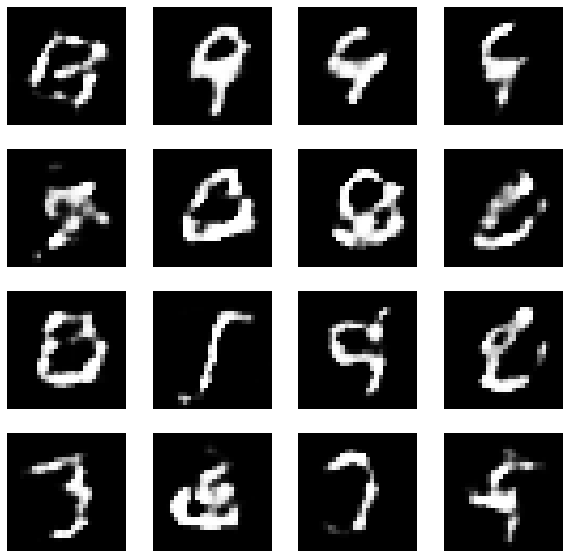

Época:  76


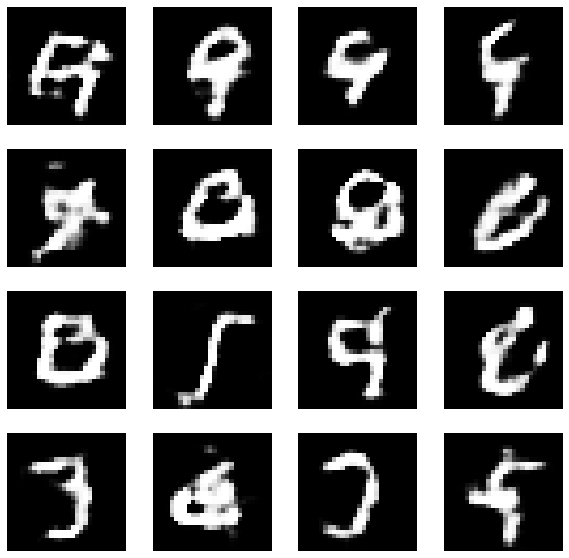

Época:  77


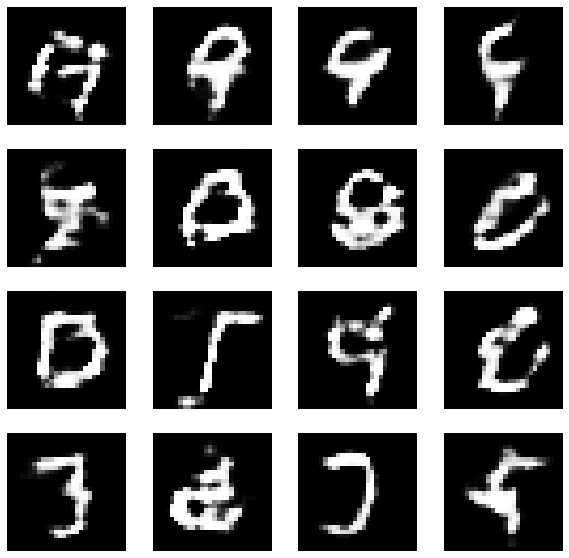

Época:  78


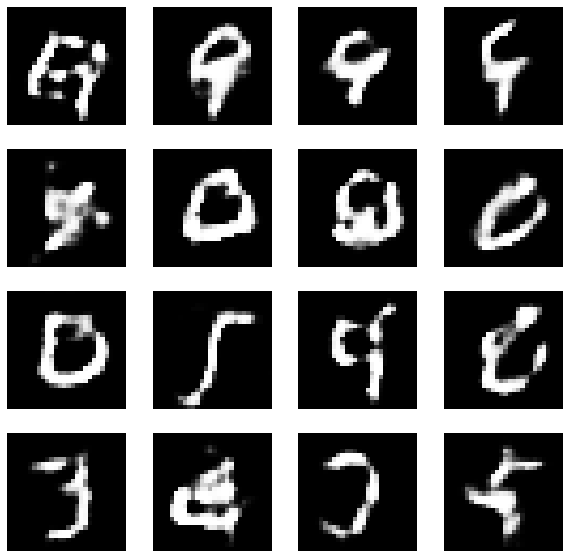

Época:  79


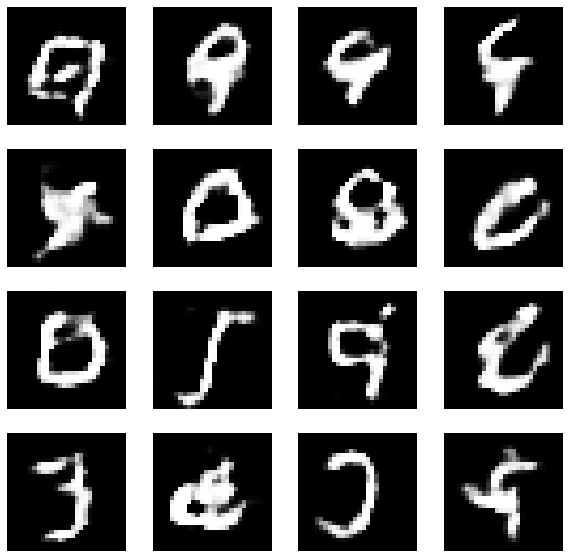

Época:  80


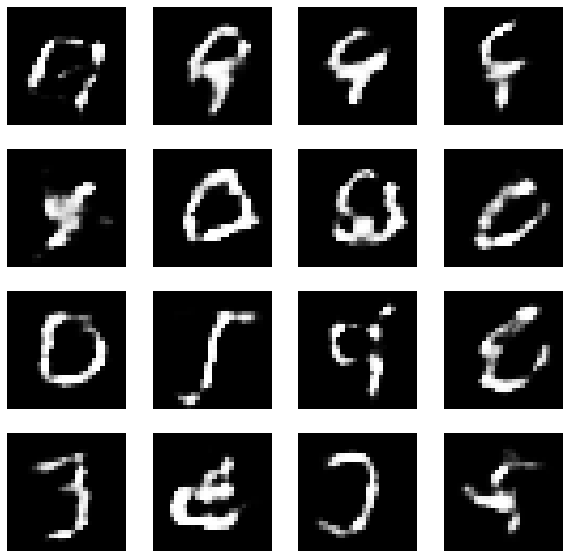

Época:  81


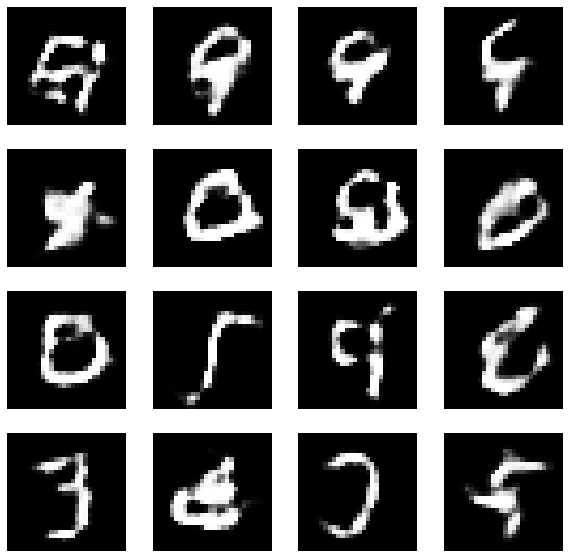

Época:  82


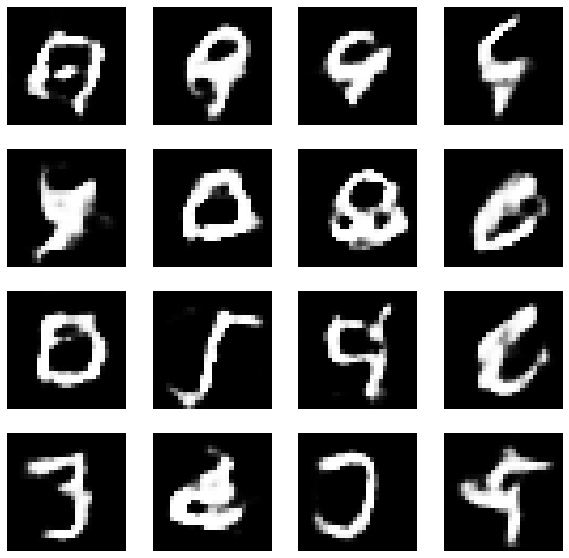

Época:  83


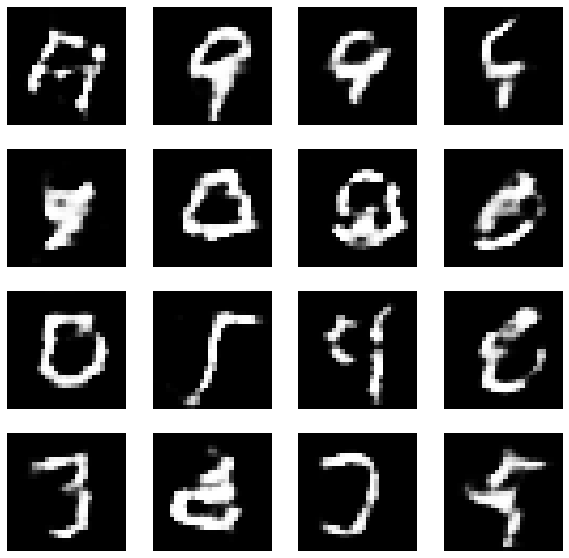

Época:  84


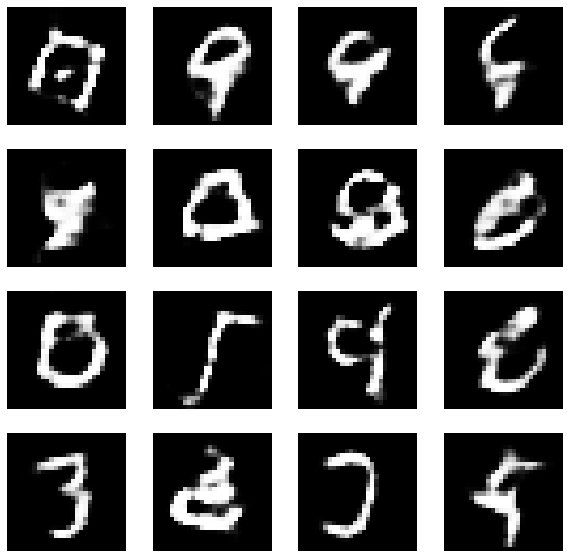

Época:  85


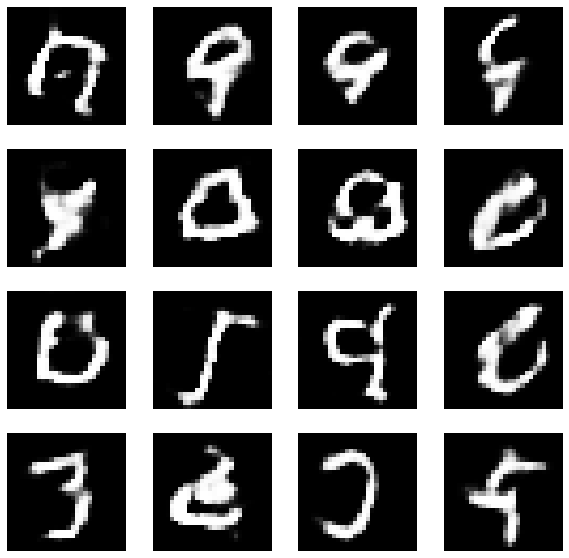

Época:  86


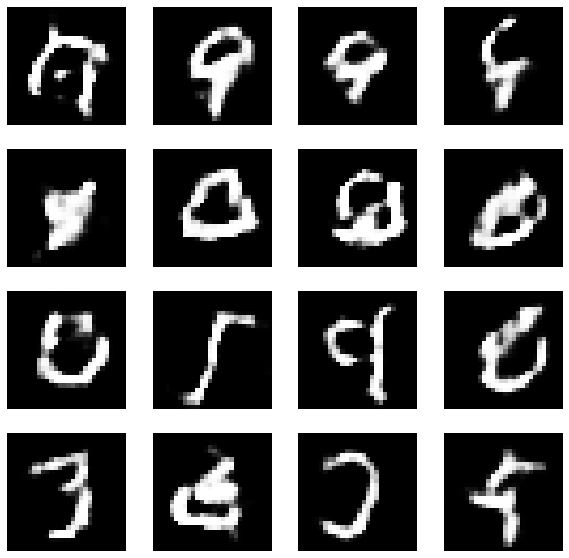

Época:  87


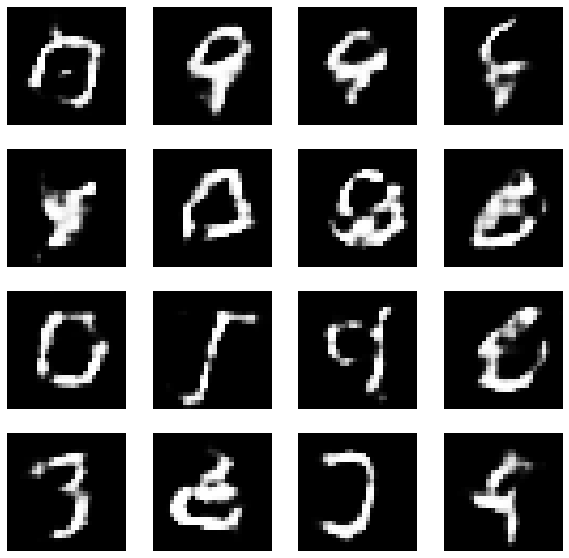

Época:  88


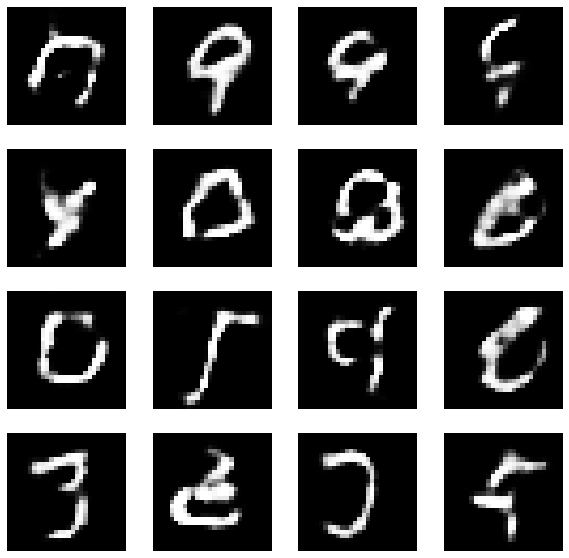

Época:  89


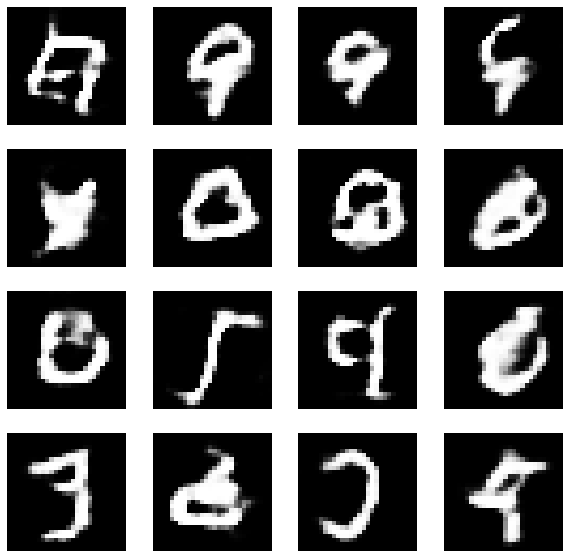

Época:  90


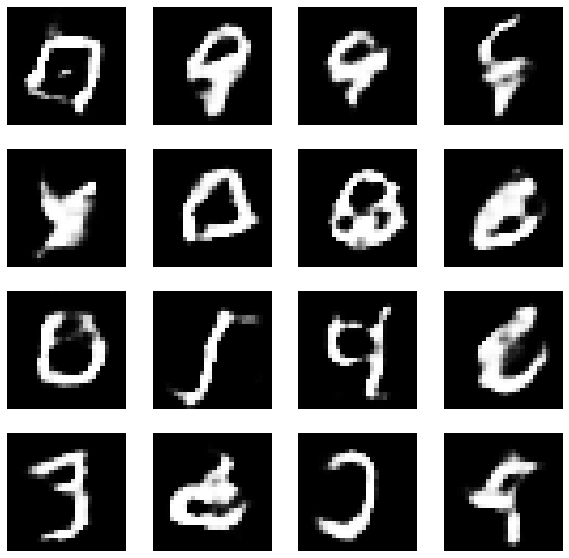

Época:  91


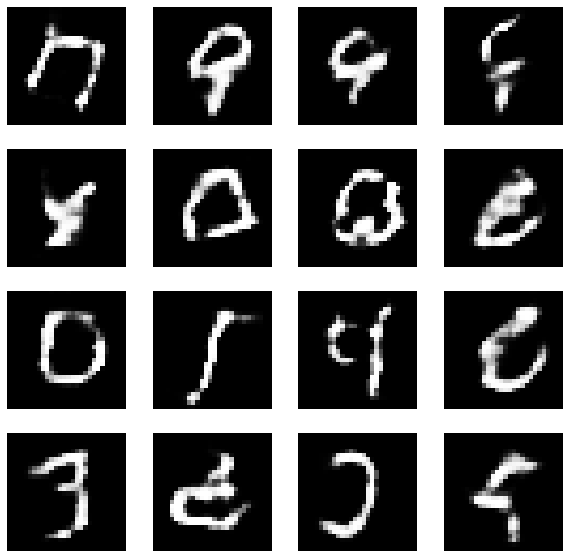

Época:  92


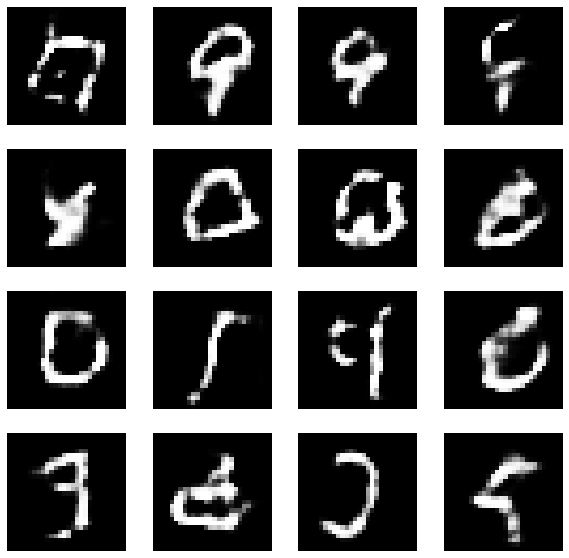

Época:  93


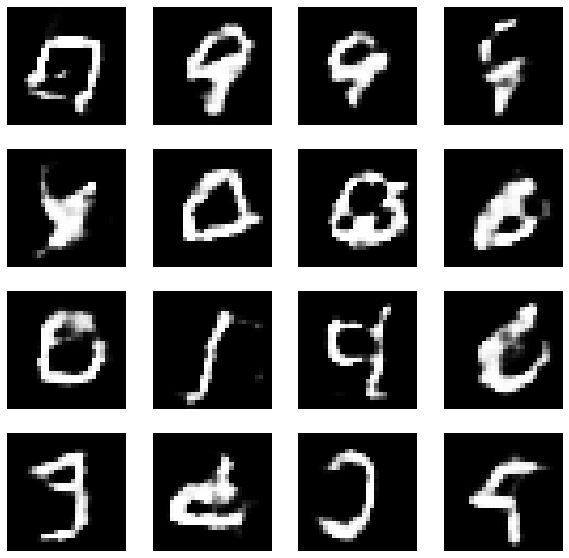

Época:  94


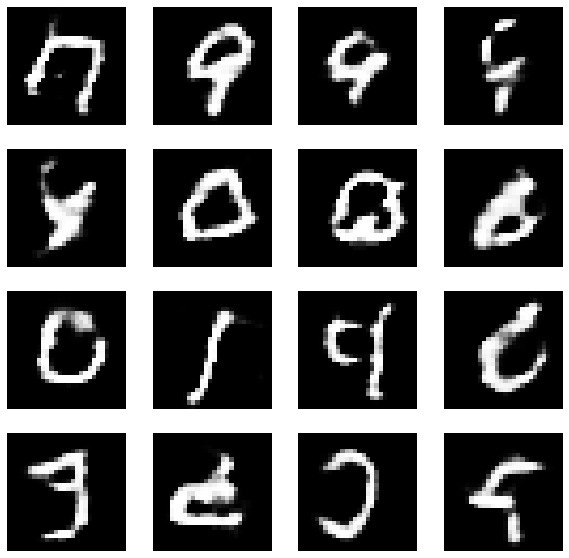

Época:  95


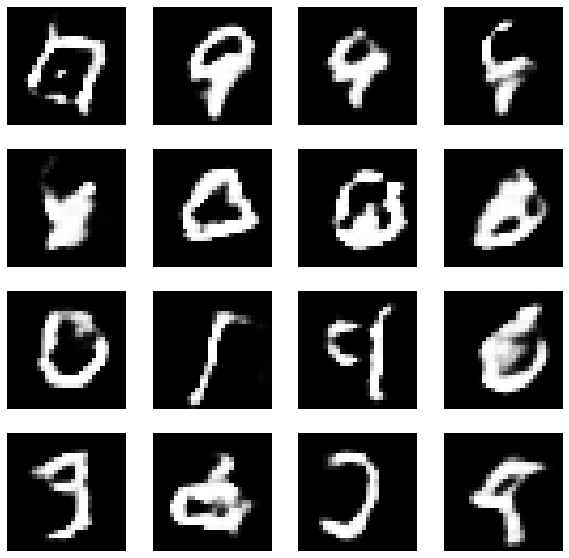

Época:  96


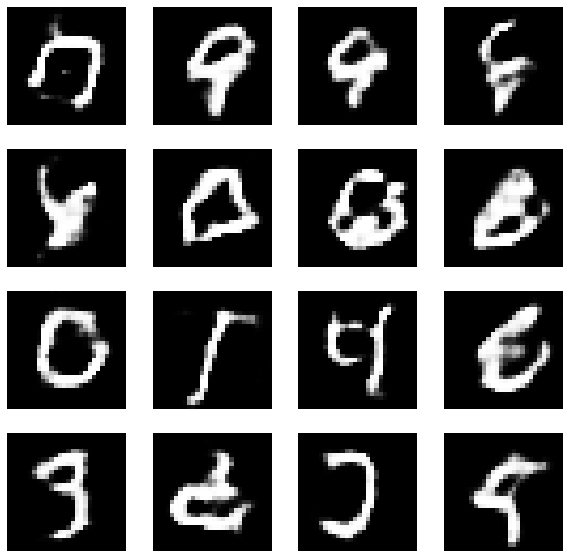

Época:  97


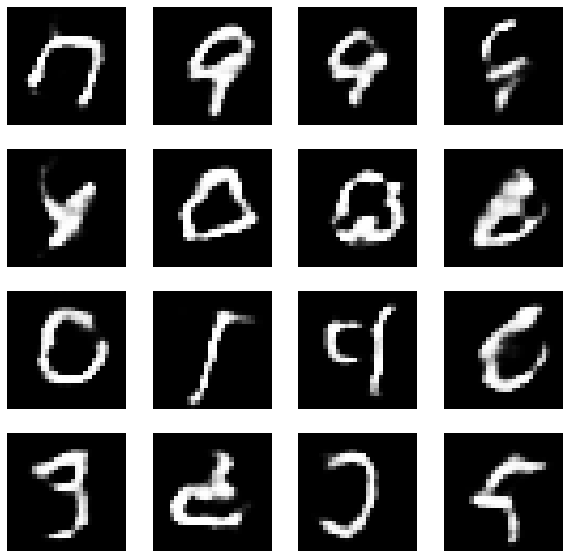

Época:  98


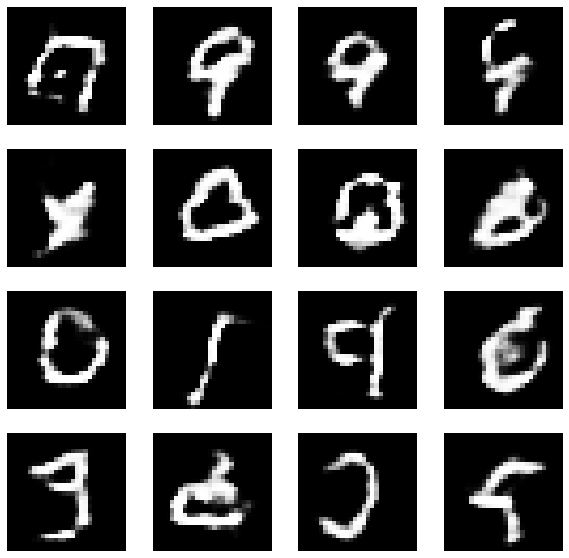

Época:  99


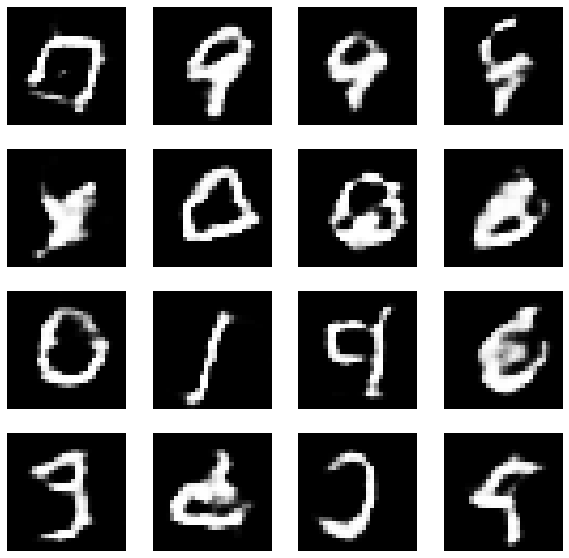

Época:  100


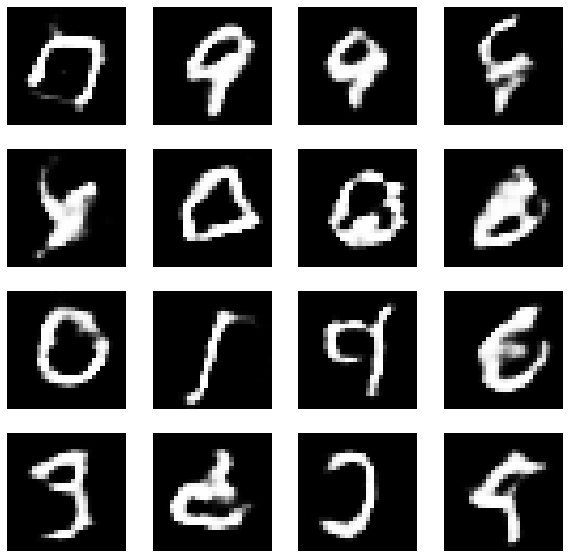

In [36]:
treina_gan(X_treinamento, epocas, imagens_teste)